In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:0

In [2]:
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox


from darts.utils.statistics import plot_acf, plot_pacf, acf, pacf

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [3]:
coursera_data = yf.download('COUR', start='2010-01-01', end='2024-09-30', interval = '1mo', progress=False)
df = coursera_data[['Close']].rename(columns={'Close': 'COUR'})

In [4]:
df.index = pd.to_datetime(df.index)
coursera_series = TimeSeries.from_series(df['COUR'])

coursera_train, coursera_val = coursera_series.split_before(pd.Timestamp('2024-01-01'))

df.tail()

,COUR
Date,
2024-05-01,7.60
2024-06-01,7.16
2024-07-01,9.30
2024-08-01,8.10
2024-09-01,7.94


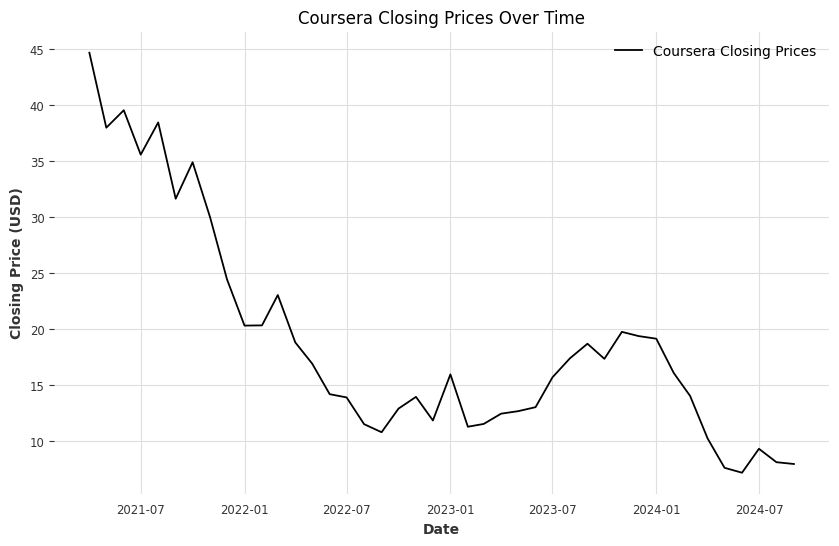

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['COUR'], label='Coursera Closing Prices')
plt.title('Coursera Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df['COUR_boxcox'], lmbda = boxcox(df['COUR'])

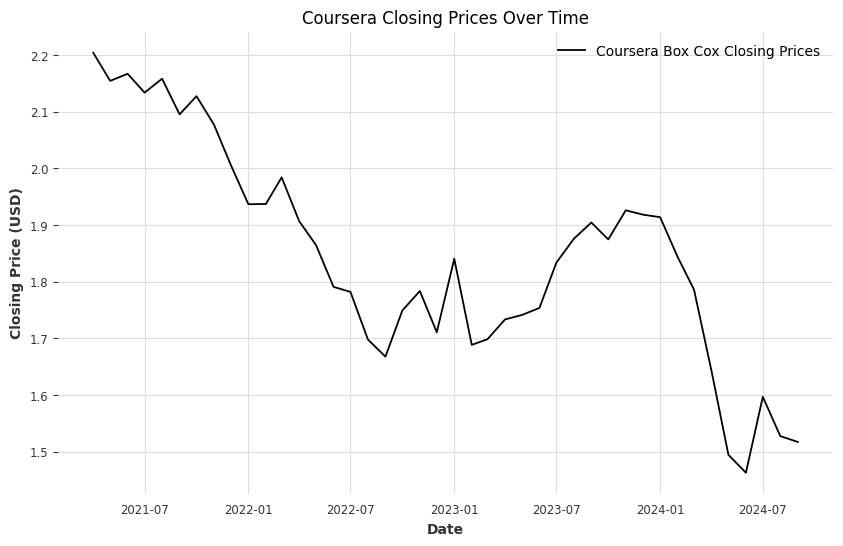

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['COUR_boxcox'], label='Coursera Box Cox Closing Prices')
plt.title('Coursera Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
df['COUR_diff'] = df['COUR'].diff().dropna()

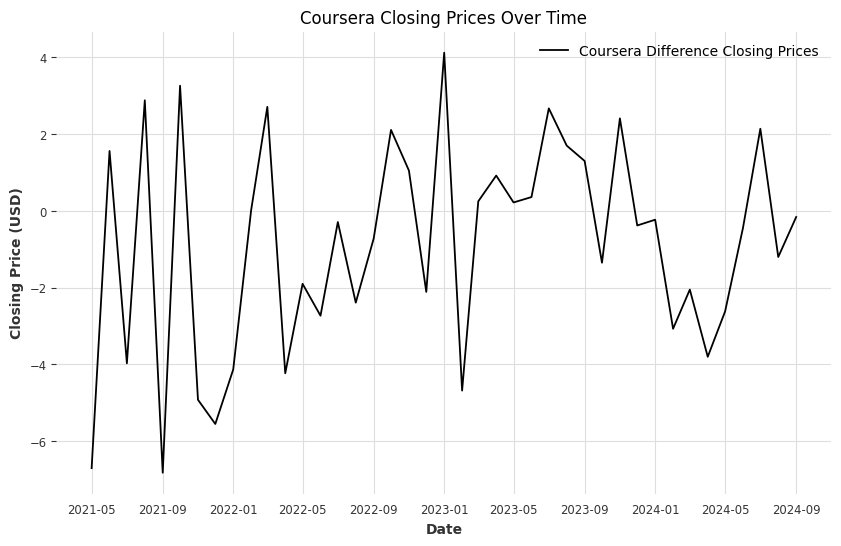

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['COUR_diff'], label='Coursera Difference Closing Prices')
plt.title('Coursera Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
train_data = coursera_train.pd_series()
model = ExponentialSmoothing(train_data, trend = 'add', seasonal=None)
result = model.fit()
alpha = result.params['smoothing_level']
beta = result.params['smoothing_trend']

In [11]:
alpha

0.4693375851108383

In [12]:
beta

0.30132215551195723

In [13]:
val_data = coursera_val.pd_series()
forecast_holt = result.forecast(steps=len(val_data))
mse_holt = mean_squared_error(val_data, forecast_holt)

In [14]:
mse_holt

214.72720640583734

In [15]:
decomposition_result = seasonal_decompose(train_data, model='additive', period=12)
estimated_trend = decomposition_result.trend.dropna()
estimated_seasonality = decomposition_result.seasonal.dropna()

In [17]:
poly = PolynomialFeatures(degree=3)
X = np.arange(len(estimated_trend)).reshape(-1, 1)
y = estimated_trend.values
X_poly = poly.fit_transform(X)

dates_future = pd.date_range(start='2024-01-01', end='2024-09-30', freq='MS')
X_future = np.arange(len(estimated_trend), len(estimated_trend) + len(dates_future)).reshape(-1, 1)
X_future_poly = poly.transform(X_future)

In [18]:
trend_model = LinearRegression()
trend_model.fit(X_poly, y)
predicted_poly_trend = trend_model.predict(X_future_poly)

In [19]:
future_seasonality = estimated_seasonality[-12:].head(len(dates_future)).values

In [20]:
complete_poly_trend_pred = predicted_poly_trend + future_seasonality
complete_poly_trend_pred_pd = pd.Series(complete_poly_trend_pred, index=dates_future)

In [21]:
mse_poly_trend = mean_squared_error(val_data, complete_poly_trend_pred_pd)

In [22]:
mse_poly_trend

195.16411208451012